#### Adapted from: Pattern Recognition and Machine Learning, Christopher M. Bishop

The goal with variational inference is that given some data (assumed to be gaussian) we want to infer the mean and variance, which also have some underlying distribution.

In this notebook the underlying distribution of the mean and the precision (inverse of variance) is said to be:

#### $p(μ|τ) = \mathcal{N}(μ|μ_0,(λ_0τ)^−1)$

#### $p(τ) = \mathcal{N}(τ|a_0, b_0)$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Control the randomness
np.random.seed(5)

Let us generate some data with by first setting $\mu_0, \lambda_0, a_0$, and $b_0$ and then visualize the prior distribution over $\mu$ and $\tau$.

In [15]:
# Our initial parameters for mu and tau
mu_0 = 0
k_0 = 1
a_0 = 2
b_0 = 1
N = 10
# Lets generate some data D
prior_tau = np.random.gamma(shape=a_0, scale=b_0, size=N)
prior_mu = []
for i in range(N):
    prior_mu.append(np.random.normal(mu_0, 1 / (k_0 * prior_tau[i]), size=1))
prior_tau = np.reshape(prior_tau, (1, len(prior_tau)))[0]
prior_mu = np.array(prior_mu).T[0]

#f, ax = plt.subplots(figsize=(8, 8))
#g = sns.kdeplot(prior_mu, prior_tau)
#ax.set_ylim(-1, 6)
#ax.set_xlim(-40, 40)
#plt.title("Prior distribution over μ and τ")
#plt.xlabel("μ")
#plt.ylabel("τ")


D = []
for i in range(N):
    D.append(np.random.normal(prior_mu[i], 1/prior_tau[0], size=1)[0])
D = np.array(D)
print(D)

[-0.31574092  2.18262628  1.51127254  1.53342058 -0.54469717  1.81430277
  0.51438609  0.3108902  -3.00339448  0.50771551]


### TODO 
Update equations for $q(\mu)$:

$\mu_N$ = $\frac{\kappa_0\mu_0 + N\bar{x}}{\kappa_0 + N}$

$\kappa_N = (\kappa_0 + N)\frac{a_N}{b_N}$

and for $q(\tau)$:

$a_N = a_0 + \frac{N + 1}{2}$

$b_N = b_0 + \kappa_0(\mathbb{E}[\mu^2] + \mu_0^2 - 2\mathbb{E}[\mu]\mu_0) + \frac{1}{1}\sum_{i=1}^N (x_i^2 + \mathbb{E}[\mu^2] - 2\mathbb{E}[\mu]x_i)$

In [20]:
mu_N = (k_0 * mu_0 + np.sum(D)) / (k_0 + N)
a_N = a_0 + (N + 1) / 2
Emu = mu_N
changed = 0

k_N_last = 1
b_N_last = 5
i = 0
while True:
    i += 1
    Emu2 = (1 / k_N_last) + np.power(mu_N, 2)
    last_sum = 0
    for i in range(N):
        last_sum += np.power(D[i], 2) + Emu2 - 2 * Emu * D[i]
    b_N = b_0 + k_0 * (Emu2 + np.power(mu_0, 2) - 2 * Emu * mu_0) + (1 / 2) * last_sum
    if abs(b_N - b_N_last) <= 10**-10:
        changed += 1
    b_N_last = b_N
    
    k_N = (k_0 + N)*(a_N / b_N)
    if abs(k_N - k_N_last) <= 10**-10:
        changed += 1
    k_N_last = k_N
    if changed == 2:
        print("Done after", i, "iterations.")
        break
    changed = 0

Done after 9 iterations.


7.5 12.426268305412043 0.41007103517593324


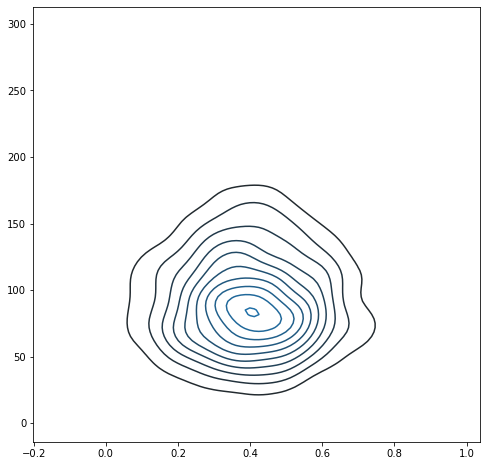

In [21]:
mu_g = np.random.normal(mu_N, 1/k_N_last, size=1000)
tau_g = np.random.gamma(a_N, b_N, size=1000)

f, ax = plt.subplots(figsize=(8, 8))
g = sns.kdeplot(mu_g, tau_g)
print(a_N, b_N, mu_N)

In [22]:
D = []
for i in range(100):
    D.append(np.random.normal(mu_g[i], 1/tau_g[i], size=1)[0])
D = np.array(D)
print(D)

[ 0.32082598  0.25640214  0.32437312  0.59917545  0.58253357  0.63310243
  0.30813328  0.36542401  0.35567941  0.34452011  0.25007632  0.3721334
  0.30680885  0.51520088  0.49016716  0.42868083  0.29970324  0.06717899
  0.3999594   0.40150109  0.03524105  0.55617034  0.14990047  0.31676114
  0.54744742  0.5133606   0.46934211  0.64755078  0.36054591  0.51016279
  0.38533569 -0.04511946  0.17001466  0.53057288  0.37687035  0.57241805
  0.21365073  0.31707833  0.46929448  0.54603932  0.35858658  0.48117818
  0.18153813  0.54504373  0.24906534  0.41124505  0.44314242  0.50534538
  0.50621964  0.75780816  0.4138734   0.50917298  0.43359686  0.46697545
  0.48707216  0.54894889  0.28216603  0.34167148  0.34164209  0.42874315
  0.25379193  0.40961415  0.23534505  0.47628012  0.36550248  0.51817275
  0.38772067  0.20296597  0.32071552  0.29700085  0.30368413  0.48032376
  0.3627087   0.41537685  0.40556305  0.30823596  0.23821124  0.59091509
  0.46442702  0.4096599   0.38260038  0.39895205  0.